# 인구 소득 예측 경진대회

## 데이터 불러오기

In [328]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [5]:
sns.set_theme()

In [6]:
SEED = 22

In [7]:
os.chdir('C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\인구-소득-예측')

In [205]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

|변수 이름 |세부 사항 |
|:-:|:-:|
|id | 샘플 아이디|
|age | 나이|
|workclass | 일 유형|
|fnlwgt | CPS(Current Population Survey) 가중치|
|education | 교육수준|
|education.num | 교육수준 번호(클수록 높은 학위)|
|marital.status | 결혼 상태|
|occupation| 직업|
|relationship | 가족관계|
|race | 인종|
|sex |성별|
|capital.gain | 자본 이익|
|capital.loss | 자본 손실|
|hours.per.week |주당 근무시간|
|native.country | 본 국적|
|target | 소득(0: <=50K, 1: >50K)|

In [206]:
df.isnull().sum()

id                   0
age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
target               0
dtype: int64

`-` `workclass`, `occupation`, `native.country` 변수에 결측치가 존재한다

## 데이터 전처리

`-` 분석의 편의성을 위해 변수명의 `.`을 `_`으로 바꾸겠다

In [207]:
def replace_dot2underbar(df) -> None:
    """데이터프레임의 변수명에 포함된 .(dot)을 _(underbar)로 변경한다"""
    df.rename(columns = dict(zip(df.columns, [column.replace('.', '_') for column in df.columns])), inplace=True) 

In [208]:
replace_dot2underbar(df)

In [242]:
replace_dot2underbar(test)

In [209]:
df.columns

Index(['id', 'age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'target'],
      dtype='object')

`-` 잘 바뀌었다

`-` 이제 변수 타입을 확인하자

In [210]:
df.dtypes

id                 int64
age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
target             int64
dtype: object

`-` 상식에 벗어나는 타입을 가진 변수는 없다

`-` 그런데 수치로 코딩된 범주형 변수가 있어서 일일이 바꿔주자

In [211]:
df['education_num'] = df['education_num'].astype('str')
df['target'] = df['target'].map({1:'>50K', 0:'<=50K'})

`-` 오브젝트 타입 변수의 유니크한 값의 개수를 확인하자

In [212]:
df.dtypes[df.dtypes == 'object']

workclass         object
education         object
education_num     object
marital_status    object
occupation        object
relationship      object
race              object
sex               object
native_country    object
target            object
dtype: object

## EDA

### 범주형 변수 시각화

`-` plot에 비율 text를 추가해보자

In [130]:
def show_unique_counts(df_: pd.DataFrame, target: str) -> None:
    """ df의 변수 중에서 범주형 변수의 unique한 값의 개수를 시각화하는 함수"""
    df = df_.copy()
    df = df.dropna() ## 결측치 제거
    ## len(df.columns[df.dtypes == 'object'])의 결과를 보고 적절한 shape을 수동으로 지정해야 한다
    ## 결과값이 10이므로 5 X 2 크기의 figure를 만들자
    row, column = 5, 2
    fig, axs = plt.subplots(row, column, figsize=(14, 28))
    features = df.columns[df.dtypes == 'object']
    
    for i, feature in enumerate(features):
        ax = axs[i // column][i % column]
        sns.countplot(data=df, y=feature, hue=target, order=df[feature].value_counts().index, dodge=False, ax=ax)
    
    fig.suptitle("Categorical feature's Unique Counts\n", x=0.56, fontsize=25) ## default: x=0.5, y=0.98
    fig.tight_layout()

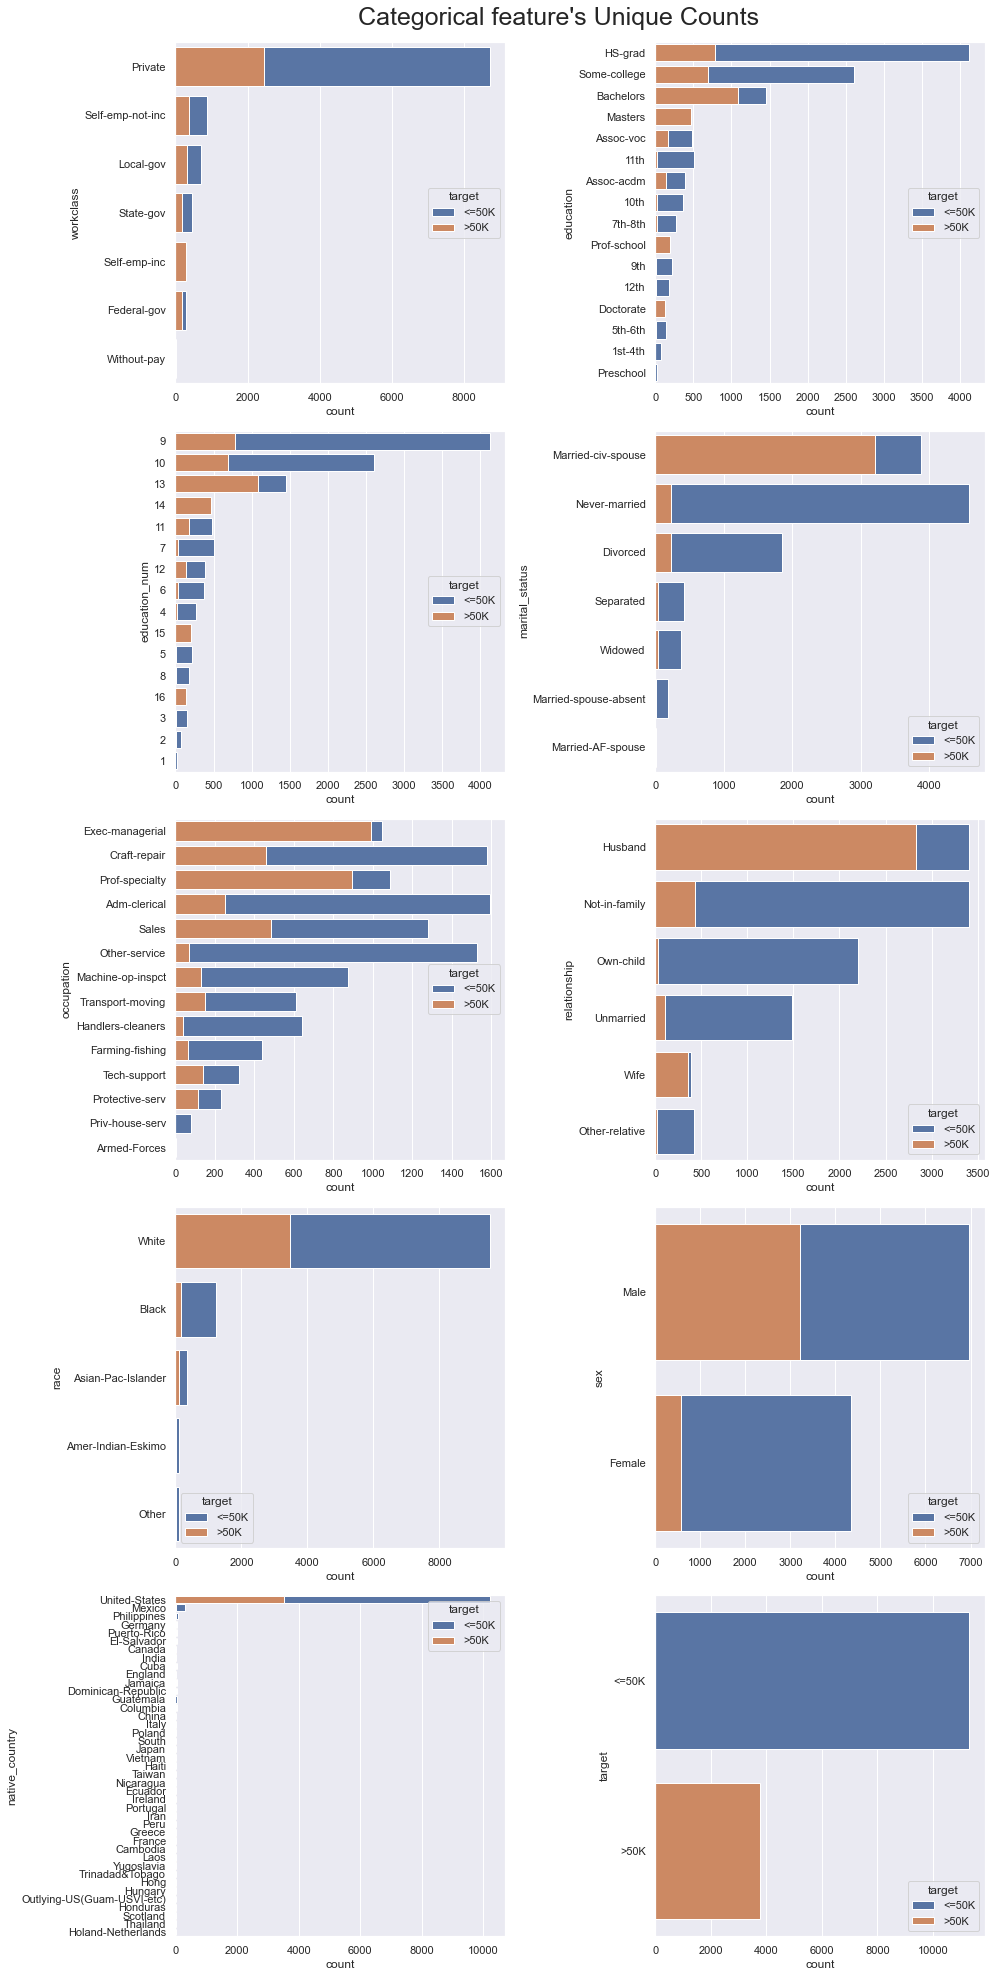

In [131]:
show_unique_counts(df, 'target')

`-` 막대그래프는 count 값을 기준으로 오름차순 정렬됐다(안된건 뭐지?, $y$축을 잘 확인하자)

`-` 미국인 대상으로 조사한 거라 `native_country` 변수의 대부분이 United-States이다

`-` 3개 범주정도만 막대그래프가 보이고 나머지는 상대적으로 너무 적은 나머지 보이지도 않는다...

`-` 나중에 수치로 변환할 때 `Other`로 인코딩하는 것을 고려하자

`-` 소득 범주인 `>50K`과 `<=50K`의 비율 차이가 많이 나는 피쳐의 범주가 존재한다(예컨대 교육번호 피쳐의 $13$, $14$) 

`-` 소득이 50K보다 작은 사람이 50K보다 많은 사람의 3배이다(불균형 클래스)

- 직업이 결측치인 경우

`-` 직업이 결측치인 경우는 사실 직업이 없는게 아닐까? 

`-` workclass에서 Without-pay는 직업이 없는게 아니라 돈을 안받는 직업같다(근데 돈을 받아야 직업 아닌가?...)

`-` 근데 직업이 없다기에는 Hours_per_week가 0이 아니다

`-` 범주에 속하지 않는 직업이라 생각하는 것이 나을 것 같다

`-` occupation의 결측치는 Other로 맵핑하겠다

In [213]:
df[df['occupation'].isnull()].target.value_counts()

<=50K    1652
>50K      191
Name: target, dtype: int64

In [214]:
df.loc[df['occupation'].isnull(), 'occupation'] = 'Other'

`-` 국가도 결측치 처리를 하자

In [215]:
df.loc[df['native_country'].isnull(), 'native_country'] = 'Other'

### 양적 변수 시각화

`-` 소득 범주에 따른 violin plot을 그려보자

In [133]:
def show_violinplot(df_: pd.DataFrame, target: str) -> None:
    """ target 범주에 따른 양적 변수의 분포를 박스 플랏을 사용해 시각화하는 함수"""
    df = df_.copy()
    df = df.dropna() ## 결측치 제거
    ## len(df.columns[(df.dtypes == float) | (df.dtypes == np.int64)])의 결과를 보고 적절한 shape을 수동으로 지정해야 한다
    ## 결과값이 5이므로 2 X 3 크기의 figure를 만들자
    row, column = 2, 3
    fig, axs = plt.subplots(row, column, figsize=(16, 12))
    features = df.columns[(df.dtypes == float) | (df.dtypes == np.int64)]
    
    for i, feature in enumerate(features):
        ax = axs[i // column][i % column]
        sns.violinplot(data=df, y=feature, x=target, ax=ax)
        
    fig.suptitle("Box Plot\n", fontsize=25) ## default: x=0.5, y=0.98
    fig.tight_layout()

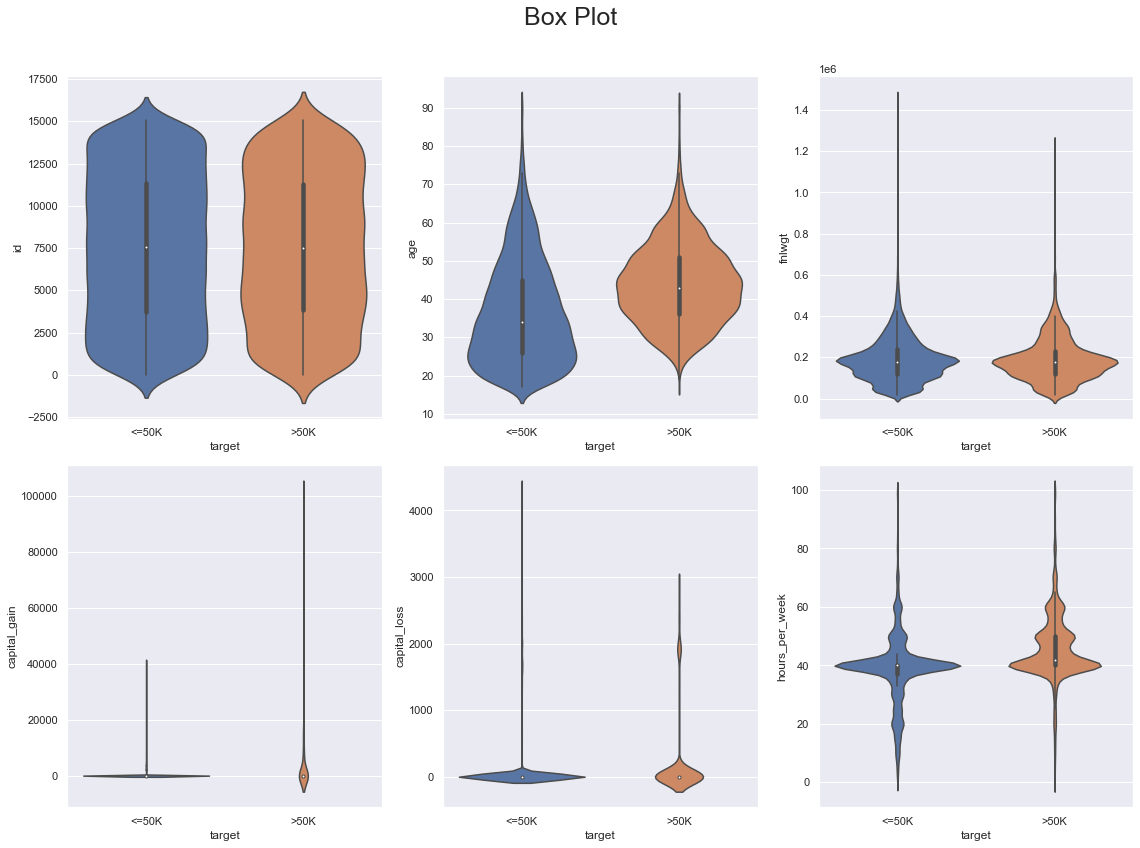

In [134]:
show_violinplot(df, 'target')

`-` 수입이 50K 이상인 사람이 평균적으로 나이가 더 많다

`-` `fnlwgt`은 수입과 관계가 없어보인다

`-` `capital_gain`과 `capital_loss`는 대부분 $0$에 값이 쏠려있다

`-` 그래서 둘다 꼬리가 긴 분포인데 자본 이익은 수입이 50K 이상인 사람들 분포의 꼬리가 더 길고

`-` 자본 손실은 수입이 50K 이하인 사람들 분포의 꼬리가 더 길다

`-` 수입이 50K 이상인 집단들의 자본 손실 분포를 보면 $2000$ 부근에 데이터가 좀 있는 것으로 보인다(why?)

`-` `hours_per_week`의 분포는 두 집단이 비슷한데 수입이 50K 이상인 집단이 조금 더 일을 많이 하는 경향이 있다

<AxesSubplot:>

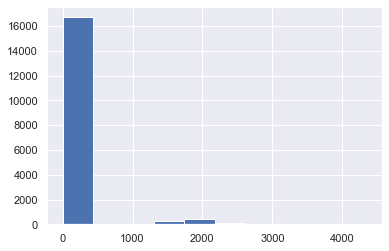

In [114]:
df['capital_loss'].hist()

`-` 신기한 분포이다...

In [115]:
df['captital_loss_approx2000'] = 'No' ## 이런거 변수명 어떻게 지음...

In [116]:
df.loc[(df['capital_loss'] >= 1500) & (df['target'] == '>50K') & (df['capital_loss'] < 2300), 'captital_loss_approx2000'] = 'Yes'

`-` 확인해봤는데 잘 모르겠다

`-` 원래의 분포와 비슷하게 생겼다

In [119]:
df.drop('captital_loss_approx2000', axis=1, inplace=True)

## 모델링

### 인코딩

`-` 교육수준 번호는 범주값 자체로 맵핑하자

`-` 나머지 피쳐에 대해선 target의 비율이 비슷한 범주는 하나로 통합시키자

`-` 예컨대 직업같은 경우 직업의 이름 때문에 소득 차이가 발생하는게 아니라

`-` 그 직업이 하는 일이 돈을 많이 벌 수 있냐 아니냐에 따라서 차이가 생긴다

`-` 이를 직업(돈을 많이 벌 수 있는 가치가 있냐 없냐)의 특성으로 보고 같은 특성을 가지는 직업끼리 합치겠다

`-` 또한 occupation을 유형에 따라 나눈게 workclass인데 occupation이 더 세부적이고 target이 극단적으로 나뉘는 범주도 더 많으므로 workclass는 쓰지 않겠다

`-` 그리고 education은 education_num이 있으니까 사용하지 않겠다(education을 라벨인코딩 한 것이 education_num이다)

`-` 혼인 여부와 가족 관계 피쳐는 알맞게 하나로 합쳐서 사용하겠다(어떤식으로 합치는지는 코드 참고)

`-` race는 White와 Ohter로 인코딩하겠다

`-` native_country는 United_States와 Ohter로 인코딩하겠다(근데 대부분이 미국이라 그냥 드랍함)

`-` relationship은 Husband, Wife, Not-in-family, Ohter로 인코딩하겠다

`-` fnlwgt은 플랏을 보니 target과 관련이 없어보여 드랍하고 자본 손실과 자본 이득은 로그 변환하겠다

In [243]:
df['education_num'] = df['education_num'].astype('int')

In [216]:
df['target'] = df['target'].map({'<=50K':0, '>50K':1}) 

In [1167]:
def drop_features(df_: pd.DataFrame) -> pd.DataFrame:
    df = df_.copy()
    try:
        df.drop(['id', 'workclass', 'education', 'native_country', 'fnlwgt'], axis=1, inplace=True)
    except:
        print('이미 drop된 feature가 있습니다')
    return df

In [1164]:
def feature_encoding(df_: pd.DataFrame) -> pd.DataFrame:
    df = df_.copy()
    
    df['race'] = df['race'].apply(lambda race: race if race == 'White' else 'Other')
    # df['native_country'] = df['native_country'].apply(lambda country: country if country == 'United-States' else 'Other')
    df['occupation'] = df['occupation'].map({'Exec-managerial':'Ex',
                                             'Prof-specialty':'Ex',
                                             'Craft-repair':'Gd',
                                             'Sales':'Gd',
                                             'Tech-support':'Gd',
                                             'Protective-serv':'Gd',
                                             'Adm-clerical':'TA',
                                             'Machine-op-inspct':'TA',
                                             'Transport-moving':'TA',
                                             'Farming-fishing':'TA',
                                             'Other-service':'Fa',
                                             'Handlers-cleaners':'Fa',
                                             'Priv-house-serv':'Fa',
                                             'Armed-Forces':'Fa',
                                             'Other':'Fa'})
                                             
    df['marital_status'] = df['marital_status'].map({'Widowed':'Solo',
                                                     'Separated':'Solo',
                                                     'Married-spouse-absent':'Solo',
                                                     'Married-AF-spouse':'Solo',
                                                     'Divorced':'Solo',                                                
                                                     'Married-civ-spouse':'Married',
                                                     'Never-married':'NotMarried'})
    
    df['relationship'] = df['relationship'].map({'Own-child':'Other',
                                                 'Other-relative':'Other',
                                                 'Husband':'Man',
                                                 'Wife':'Woman',
                                                 'Not-in-family':'Alone',
                                                 'Unmarried':'Alone'})
    
    ## 새로운 피쳐 생성
    df['family_relationship'] = df['marital_status'] + '-' + df['relationship']
    
    ## 문자형을 카테고리형으로 변환
    for feature in df.columns[df.dtypes == 'O']:
        df[feature] = df[feature].astype('category')
        
    ## 쓸모없는 피쳐 드랍
    df.drop(['marital_status', 'relationship'], axis=1, inplace=True)
    
    return df

In [1169]:
def preprocessing(df_: pd.DataFrame) -> pd.DataFrame:
    df = df_.copy()
    ## step1
    df = drop_features(df)
    
    ## step2
    df['capital_gain'] = df['capital_gain'].apply(lambda x: np.log1p(x))
    df['capital_loss'] = df['capital_loss'].apply(lambda x: np.log1p(x))
    
    ## step3
    df = feature_encoding(df)
    
    ## return
    return df

In [1170]:
df2 = preprocessing(df)

In [1171]:
df2.head()

,age,education_num,occupation,race,sex,capital_gain,capital_loss,hours_per_week,target,family_relationship
0,32,12,Gd,White,Male,0.0,0.0,40,0,Married-Man
1,33,10,Ex,White,Male,0.0,0.0,40,1,Married-Man
2,46,10,Gd,White,Male,0.0,0.0,40,0,Married-Man
3,23,13,TA,White,Female,0.0,0.0,30,0,NotMarried-Other
4,55,9,TA,White,Female,0.0,0.0,40,0,Solo-Alone


In [910]:
test2 = preprocessing(test)

In [911]:
test2.head()

,age,fnlwgt,education_num,occupation,race,sex,capital_gain,capital_loss,hours_per_week,family_relationship
0,47,12.625224,10,Ex,White,Male,0.00000,0.0,45,Married-Man
1,34,11.946187,10,Gd,White,Male,0.00000,0.0,75,NotMarried-Alone
2,31,11.972197,13,Gd,White,Male,9.06126,0.0,40,NotMarried-Alone
3,28,12.118094,13,Ex,White,Male,0.00000,0.0,55,Married-Man
4,54,12.114747,10,TA,White,Female,0.00000,0.0,40,Solo-Alone


### 모델 생성 및 학습

In [58]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [240]:
## accuracy 계산
def ACCURACY(true, pred):
    return sum(true == pred) / len(true)

In [940]:
k = 5
skfold = StratifiedKFold(k, shuffle=True, random_state=SEED)

In [912]:
target = df2['target']

In [1172]:
df2.drop(['target'], axis=1, inplace=True) 

In [915]:
CB = CatBoostClassifier(n_estimators=750,
                       learning_rate=0.06,
                       depth=5,
                       random_state=SEED,
                       verbose=0)

In [946]:
LGBM = LGBMClassifier(n_estimators=700,
                      learning_rate=0.05,
                      max_depth=4,
                      random_state=SEED)

In [500]:
def OOF_predict(model, X, y, test, SKfold, threshold=0.5):
    """
    Out-Of-Fold 방식을 통해 test를 예측
    """ 
    model_valid_score = []
    model_predict = np.zeros(shape=(test.shape[0], len(y.unique())))

    for i, (train_idx, valid_idx) in tqdm(enumerate(SKfold.split(X, y))):
        print(f'({i + 1} / {SKfold.n_splits}) Fold Training......')
        X_train, y_train = X.iloc[train_idx], y[train_idx]
        X_valid, y_valid = X.iloc[valid_idx], y[valid_idx]
        
        if model.__class__.__name__.find('CatBoost') != -1:
            ## Catboost를 사용할 때 카테고리 피쳐 지정
            pool_train = Pool(X_train, y_train, cat_features=X.columns[X.dtypes == 'category'].tolist())
            pool_valid = Pool(X_valid, cat_features=X.columns[X.dtypes == 'category'].tolist())
            pool_test = Pool(test, cat_features=test.columns[test.dtypes == 'category'].tolist())
        
            ## model 적합
            model.fit(pool_train)
        
            ## valid, test 예측
            y_predict = model.predict_proba(pool_valid)
            test_predict = model.predict_proba(pool_test)  ## 각 클래스별 확률(test)을 구함
        else:
            ## model 적합
            model.fit(X_train, y_train)
            
            ## valid, test 예측
            y_predict = model.predict_proba(X_valid)
            test_predict = model.predict_proba(test)  ## 각 클래스별 확률(test)을 구함
            
        ## valid 예측
        y_predict = (y_predict[:, 1] > threshold).astype(int) ## 1번째 컬럼(1일 확률)의 값이 threshold보다 크면 1 아니면 0으로 계산
        model_valid_score.append(ACCURACY(y_predict, y_valid)) ## valid 정확도
        
        ## test 합산
        model_predict += test_predict / SKfold.n_splits ## test 예측값(k Fold)
    
    ## prob를 바탕으로 argmax 계산
    # model_predict = model_predict.argmax(-1)  ## 주석처리하면 확률을 반환             
    return model_valid_score, model_predict

In [947]:
LGBM_valid_acc, LGBM_test_pred = OOF_predict(LGBM, df2, target, test2, skfold, threshold=0.5)

0it [00:00, ?it/s]

(1 / 5) Fold Training......


1it [00:00,  1.33it/s]

(2 / 5) Fold Training......


2it [00:01,  1.40it/s]

(3 / 5) Fold Training......


3it [00:02,  1.41it/s]

(4 / 5) Fold Training......


4it [00:02,  1.42it/s]

(5 / 5) Fold Training......


5it [00:03,  1.40it/s]


In [906]:
CB_valid_acc, CB_test_pred = OOF_predict(CB, df2_, target, test2_, skfold, threshold=0.5)

0it [00:00, ?it/s]

(1 / 5) Fold Training......


1it [00:20, 20.97s/it]

(2 / 5) Fold Training......


2it [00:41, 20.52s/it]

(3 / 5) Fold Training......


3it [01:01, 20.51s/it]

(4 / 5) Fold Training......


4it [01:22, 20.63s/it]

(5 / 5) Fold Training......


5it [01:42, 20.56s/it]


In [955]:
print(f'CB 모델의 평균과 표준편차: {np.mean(CB_valid_acc)}, {np.std(CB_valid_acc)}')  

CB 모델의 평균과 표준편차: 0.8707093821510297, 0.0048711059399102795


In [954]:
print(f'LGBM 모델의 평균과 표준편차: {np.mean(LGBM_valid_acc)}, {np.std(LGBM_valid_acc)}') 

LGBM 모델의 평균과 표준편차: 0.8696224256292906, 0.005364778583295285


In [951]:
test_pred = (CB_test_pred + LGBM_test_pred) / 2

In [952]:
submission['target'] = (LGBM_test_pred[:, 1] > 0.5).astype(int)
submission.head()

,id,target
0,0,1
1,1,0
2,2,1
3,3,1
4,4,0


In [957]:
submission.to_csv('./Data/submission_CB-LGBM-OOF2.csv', index=False)

`-` 점수는 $0.8669761273$

### 오버샘플링

In [783]:
from imblearn.over_sampling import SMOTE

In [666]:
def label_encoding(df_: pd.DataFrame) -> pd.DataFrame:
    """카테고리형 변수의 범주에 target의 비율에 따라 수치를 맵핑한다"""
    df = df_.copy()
    df['sex'] = df['sex'].map({'Male':1, 'Female':0}).astype(int)
    df['occupation'] = df['occupation'].map({'Ex':3, 'Gd':2, 'TA':1, 'Fa':0}).astype(int)
    df['race'] = df['race'].map({'White':1, 'Other':0}).astype(int)
    df['family_relationship'] = df['family_relationship'].map({'Married-Woman':10,
                                                               'Married-Man':9,
                                                               'NotMarried-Alone':8,
                                                               'NotMarried-Other':7,
                                                               'Married-Other':6,
                                                               'Married-Alone':5,
                                                               'Solo-Man':4,
                                                               'Solo-Woman':3,
                                                               'Solo-Alone':2,
                                                               'Solo-Other':1}).astype(int)  
    return df

In [667]:
df3 = label_encoding(df2)

In [671]:
test3 = label_encoding(test2)

`-` 오버샘플링을 하고 성능을 비교하자

In [1132]:
smote = SMOTE(sampling_strategy=0.38, random_state=SEED)

In [1133]:
df_over, target_over = smote.fit_resample(df3, target)

In [1134]:
df_over.drop('fnlwgt', axis=1, inplace=True)

In [1148]:
LGBM_over = LGBMClassifier(n_estimators=700,
                           learning_rate=0.06,
                           max_depth=4,
                           random_state=SEED)

In [1149]:
LGBM_over_valid_acc, LGBM_over_test_pred = OOF_predict(LGBM_over, df_over, target_over, test3, skfold, threshold=0.5)

0it [00:00, ?it/s]

(1 / 5) Fold Training......


1it [00:00,  1.28it/s]

(2 / 5) Fold Training......


2it [00:01,  1.42it/s]

(3 / 5) Fold Training......


3it [00:02,  1.43it/s]

(4 / 5) Fold Training......


4it [00:02,  1.44it/s]

(5 / 5) Fold Training......


5it [00:03,  1.39it/s]


In [1150]:
print(f'LGBM_over 모델의 평균과 표준편차: {np.mean(LGBM_over_valid_acc)}, {np.std(LGBM_over_valid_acc)}')

LGBM_over 모델의 평균과 표준편차: 0.856306326800601, 0.005784766854617765


`-` 오버샘플링을 사용하니 성능이 더 안좋아졌다

`-` 근데 이건 라벨 인코딩을 이상하게 해서 그런걸 수 있다

In [1151]:
submission['target'] = (LGBM_over_test_pred[:, 1] > 0.5).astype(int)
submission.head()

,id,target
0,0,1
1,1,0
2,2,1
3,3,1
4,4,0


In [1152]:
submission.to_csv('./Data/submission_LGBM-Over.csv', index=False)

`-` 점수는 $0.8616710875$